In [1]:
"""
    Dataset (Bangla ( Bengali ) sentiment analysis classification benchmark dataset corpus) : https://data.mendeley.com/datasets/p6zc7krs37/4
"""
from gensim.models import KeyedVectors
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from matplotlib import pyplot
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors
import pandas as pd
import string
import numpy as np
import numpy as np
import pandas as pd
from gensim.models.word2vec import Word2Vec
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.layers import *
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import *
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import PorterStemmer
from sklearn import preprocessing
from tensorflow.keras import mixed_precision
import tensorflow as tf
tf.keras.mixed_precision.experimental.Policy('mixed_float16')
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, LearningRateScheduler
from keras.regularizers import l2

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce GTX 1660, compute capability 7.5


In [2]:
lstm_units = 10
w_decay = 0.05
dropout_rate = 0.2
epochs_to_run = 500
sequence_length = 200

In [3]:
# Loading Bangla ( Bengali ) sentiment analysis classification benchmark dataset
positive_sentences = []
f = open('../datasets/all_positive_8500.txt','r', encoding = 'utf-8')
for line in f:
    positive_sentences.append(line.strip())

negative_sentences = []
f = open('../datasets/all_negative_3307.txt','r', encoding = 'utf-8')
for line in f:
    negative_sentences.append(line.strip())
    
print(len(positive_sentences), 'positive sentences')
print(len(negative_sentences), 'negative sentences')

import random
random.shuffle(positive_sentences)

for i in range(len(positive_sentences)-len(negative_sentences)):
    positive_sentences.pop(0)

print(len(positive_sentences), 'positive sentences')
print(len(negative_sentences), 'negative sentences')


y_pos = [1 for i in range(len(positive_sentences))]
y_neg = [0 for i in range(len(negative_sentences))]

X = positive_sentences + negative_sentences
y = y_pos + y_neg

8500 positive sentences
3307 negative sentences
3307 positive sentences
3307 negative sentences


In [4]:
w2v_model = Word2Vec.load("word2vec.model")
words = list(w2v_model.wv.index_to_key)
vocab_size = len(words)
print(vocab_size)

141148


In [5]:
tokenizer = Tokenizer(vocab_size)
tokenizer.fit_on_texts(X)
y = np.array(y)
X = tokenizer.texts_to_sequences(X)
X = pad_sequences(X, sequence_length)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)
X_train_val = X_train
y_train_val = y_train

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train_val, test_size=0.2, random_state=1, stratify=y_train_val)



In [6]:
from tensorflow.keras.layers import Embedding
def gensim_to_keras_embedding(model, train_embeddings=False):
    """Get a Keras 'Embedding' layer with weights set from Word2Vec model's learned word embeddings.

    Parameters
    ----------
    train_embeddings : bool
        If False, the returned weights are frozen and stopped from being updated.
        If True, the weights can / will be further updated in Keras.

    Returns
    -------
    `keras.layers.Embedding`
        Embedding layer, to be used as input to deeper network layers.

    """
    keyed_vectors = model.wv  # structure holding the result of training
    weights = keyed_vectors.vectors  # vectors themselves, a 2D numpy array    
    index_to_key = keyed_vectors.index_to_key  # which row in `weights` corresponds to which word?

    layer = Embedding(
        input_dim=weights.shape[0],
        output_dim=weights.shape[1],
        weights=[weights],
        trainable=train_embeddings,
    )
    return layer

In [7]:
def nlp_lstm(w2v):
    inputs = Input(shape=(X_train[0].shape[-1],))

    embedding_layer = gensim_to_keras_embedding(w2v)
    
    embedding = embedding_layer(inputs)

    lstm1 = LSTM(lstm_units,return_sequences=True, return_state=True, kernel_regularizer=l2(w_decay),recurrent_regularizer=l2(w_decay), dropout=dropout_rate)(embedding)
    output = Dense(units=1, activation='sigmoid')(lstm1[1])

    model = Model(inputs, output)
    return model


model = nlp_lstm(w2v_model)



checkpoint = ModelCheckpoint('./weight_cp/weight_lstm1.hdf5', save_freq="epoch",  verbose=1, monitor='val_accuracy', save_best_only=True,
    save_weights_only=False)

metrics = ['accuracy']
optimizer = Adam(0.0001)
model.compile(optimizer = optimizer, loss='binary_crossentropy', metrics=metrics)
model.summary()
history = model.fit(X_train, y_train, epochs=epochs_to_run, validation_data=(X_val, y_val), callbacks=[checkpoint])

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 200, 100)          14114800  
_________________________________________________________________
lstm (LSTM)                  [(None, 200, 10), (None,  4440      
_________________________________________________________________
dense (Dense)                (None, 1)                 11        
Total params: 14,119,251
Trainable params: 4,451
Non-trainable params: 14,114,800
_________________________________________________________________
Epoch 1/500
133/133 [==============================] - ETA: 0s - loss: 3.8011 - accuracy: 0.4688
Epoch 00001: val_accuracy improved from -inf to 0.49386, saving model to ./weight_cp\weight_lstm1.hdf5
133/133 [===========================

Epoch 23/500
133/133 [==============================] - ETA: 0s - loss: 0.6212 - accuracy: 0.7753
Epoch 00023: val_accuracy did not improve from 0.81114
133/133 [==============================] - 1s 11ms/step - loss: 0.6212 - accuracy: 0.7753 - val_loss: 0.5805 - val_accuracy: 0.8111
Epoch 24/500
133/133 [==============================] - ETA: 0s - loss: 0.6106 - accuracy: 0.7772
Epoch 00024: val_accuracy improved from 0.81114 to 0.81964, saving model to ./weight_cp\weight_lstm1.hdf5
133/133 [==============================] - 2s 13ms/step - loss: 0.6106 - accuracy: 0.7772 - val_loss: 0.5664 - val_accuracy: 0.8196
Epoch 25/500
131/133 [============================>.] - ETA: 0s - loss: 0.5930 - accuracy: 0.7865
Epoch 00025: val_accuracy improved from 0.81964 to 0.82342, saving model to ./weight_cp\weight_lstm1.hdf5
133/133 [==============================] - 2s 13ms/step - loss: 0.5926 - accuracy: 0.7864 - val_loss: 0.5548 - val_accuracy: 0.8234
Epoch 26/500
133/133 [=====================

Epoch 50/500
133/133 [==============================] - ETA: 0s - loss: 0.4870 - accuracy: 0.8273
Epoch 00050: val_accuracy did not improve from 0.85175
133/133 [==============================] - 1s 11ms/step - loss: 0.4870 - accuracy: 0.8273 - val_loss: 0.4515 - val_accuracy: 0.8432
Epoch 51/500
132/133 [============================>.] - ETA: 0s - loss: 0.4874 - accuracy: 0.8284
Epoch 00051: val_accuracy did not improve from 0.85175
133/133 [==============================] - 1s 11ms/step - loss: 0.4870 - accuracy: 0.8287 - val_loss: 0.4521 - val_accuracy: 0.8423
Epoch 52/500
133/133 [==============================] - ETA: 0s - loss: 0.4881 - accuracy: 0.8204
Epoch 00052: val_accuracy did not improve from 0.85175
133/133 [==============================] - 1s 11ms/step - loss: 0.4881 - accuracy: 0.8204 - val_loss: 0.4684 - val_accuracy: 0.8376
Epoch 53/500
130/133 [============================>.] - ETA: 0s - loss: 0.4811 - accuracy: 0.8329
Epoch 00053: val_accuracy did not improve from 

133/133 [==============================] - ETA: 0s - loss: 0.4412 - accuracy: 0.8466
Epoch 00078: val_accuracy did not improve from 0.85836
133/133 [==============================] - 1s 11ms/step - loss: 0.4412 - accuracy: 0.8466 - val_loss: 0.4148 - val_accuracy: 0.8565
Epoch 79/500
131/133 [============================>.] - ETA: 0s - loss: 0.4432 - accuracy: 0.8519
Epoch 00079: val_accuracy did not improve from 0.85836
133/133 [==============================] - 1s 11ms/step - loss: 0.4426 - accuracy: 0.8521 - val_loss: 0.4154 - val_accuracy: 0.8584
Epoch 80/500
130/133 [============================>.] - ETA: 0s - loss: 0.4346 - accuracy: 0.8543
Epoch 00080: val_accuracy did not improve from 0.85836
133/133 [==============================] - 1s 11ms/step - loss: 0.4337 - accuracy: 0.8544 - val_loss: 0.4194 - val_accuracy: 0.8555
Epoch 81/500
132/133 [============================>.] - ETA: 0s - loss: 0.4344 - accuracy: 0.8575
Epoch 00081: val_accuracy did not improve from 0.85836
133/1

Epoch 106/500
133/133 [==============================] - ETA: 0s - loss: 0.4143 - accuracy: 0.8629
Epoch 00106: val_accuracy did not improve from 0.88102
133/133 [==============================] - 1s 11ms/step - loss: 0.4143 - accuracy: 0.8629 - val_loss: 0.3973 - val_accuracy: 0.8772
Epoch 107/500
132/133 [============================>.] - ETA: 0s - loss: 0.4128 - accuracy: 0.8643
Epoch 00107: val_accuracy did not improve from 0.88102
133/133 [==============================] - 1s 11ms/step - loss: 0.4125 - accuracy: 0.8646 - val_loss: 0.4132 - val_accuracy: 0.8489
Epoch 108/500
132/133 [============================>.] - ETA: 0s - loss: 0.4134 - accuracy: 0.8632
Epoch 00108: val_accuracy did not improve from 0.88102
133/133 [==============================] - 1s 11ms/step - loss: 0.4133 - accuracy: 0.8634 - val_loss: 0.4073 - val_accuracy: 0.8546
Epoch 109/500
131/133 [============================>.] - ETA: 0s - loss: 0.4082 - accuracy: 0.8698
Epoch 00109: val_accuracy did not improve f

132/133 [============================>.] - ETA: 0s - loss: 0.3865 - accuracy: 0.8807
Epoch 00134: val_accuracy did not improve from 0.88480
133/133 [==============================] - 1s 11ms/step - loss: 0.3862 - accuracy: 0.8809 - val_loss: 0.4009 - val_accuracy: 0.8640
Epoch 135/500
132/133 [============================>.] - ETA: 0s - loss: 0.3914 - accuracy: 0.8707
Epoch 00135: val_accuracy did not improve from 0.88480
133/133 [==============================] - 1s 11ms/step - loss: 0.3917 - accuracy: 0.8705 - val_loss: 0.3821 - val_accuracy: 0.8820
Epoch 136/500
132/133 [============================>.] - ETA: 0s - loss: 0.3860 - accuracy: 0.8816
Epoch 00136: val_accuracy did not improve from 0.88480
133/133 [==============================] - 1s 11ms/step - loss: 0.3862 - accuracy: 0.8816 - val_loss: 0.3815 - val_accuracy: 0.8820
Epoch 137/500
132/133 [============================>.] - ETA: 0s - loss: 0.3904 - accuracy: 0.8731
Epoch 00137: val_accuracy did not improve from 0.88480
13

133/133 [==============================] - ETA: 0s - loss: 0.3823 - accuracy: 0.8743
Epoch 00162: val_accuracy did not improve from 0.89046
133/133 [==============================] - 1s 11ms/step - loss: 0.3823 - accuracy: 0.8743 - val_loss: 0.3822 - val_accuracy: 0.8763
Epoch 163/500
133/133 [==============================] - ETA: 0s - loss: 0.3758 - accuracy: 0.8771
Epoch 00163: val_accuracy did not improve from 0.89046
133/133 [==============================] - 1s 11ms/step - loss: 0.3758 - accuracy: 0.8771 - val_loss: 0.3764 - val_accuracy: 0.8829
Epoch 164/500
131/133 [============================>.] - ETA: 0s - loss: 0.3749 - accuracy: 0.8800
Epoch 00164: val_accuracy did not improve from 0.89046
133/133 [==============================] - 1s 11ms/step - loss: 0.3748 - accuracy: 0.8804 - val_loss: 0.3735 - val_accuracy: 0.8782
Epoch 165/500
133/133 [==============================] - ETA: 0s - loss: 0.3719 - accuracy: 0.8837
Epoch 00165: val_accuracy did not improve from 0.89046
13

130/133 [============================>.] - ETA: 0s - loss: 0.3631 - accuracy: 0.8870
Epoch 00190: val_accuracy did not improve from 0.89424
133/133 [==============================] - 1s 11ms/step - loss: 0.3632 - accuracy: 0.8871 - val_loss: 0.3651 - val_accuracy: 0.8895
Epoch 191/500
133/133 [==============================] - ETA: 0s - loss: 0.3556 - accuracy: 0.8960
Epoch 00191: val_accuracy did not improve from 0.89424
133/133 [==============================] - 1s 11ms/step - loss: 0.3556 - accuracy: 0.8960 - val_loss: 0.3678 - val_accuracy: 0.8924
Epoch 192/500
132/133 [============================>.] - ETA: 0s - loss: 0.3627 - accuracy: 0.8916
Epoch 00192: val_accuracy did not improve from 0.89424
133/133 [==============================] - 1s 11ms/step - loss: 0.3624 - accuracy: 0.8918 - val_loss: 0.3650 - val_accuracy: 0.8886
Epoch 193/500
132/133 [============================>.] - ETA: 0s - loss: 0.3595 - accuracy: 0.8890
Epoch 00193: val_accuracy improved from 0.89424 to 0.8961

131/133 [============================>.] - ETA: 0s - loss: 0.3508 - accuracy: 0.8953
Epoch 00218: val_accuracy did not improve from 0.89896
133/133 [==============================] - 1s 11ms/step - loss: 0.3513 - accuracy: 0.8951 - val_loss: 0.3601 - val_accuracy: 0.8980
Epoch 219/500
133/133 [==============================] - ETA: 0s - loss: 0.3507 - accuracy: 0.8922
Epoch 00219: val_accuracy did not improve from 0.89896
133/133 [==============================] - 1s 11ms/step - loss: 0.3507 - accuracy: 0.8922 - val_loss: 0.3627 - val_accuracy: 0.8971
Epoch 220/500
132/133 [============================>.] - ETA: 0s - loss: 0.3569 - accuracy: 0.8904
Epoch 00220: val_accuracy did not improve from 0.89896
133/133 [==============================] - 1s 11ms/step - loss: 0.3569 - accuracy: 0.8904 - val_loss: 0.3643 - val_accuracy: 0.8924
Epoch 221/500
131/133 [============================>.] - ETA: 0s - loss: 0.3479 - accuracy: 0.8946
Epoch 00221: val_accuracy did not improve from 0.89896
13

Epoch 247/500
133/133 [==============================] - ETA: 0s - loss: 0.3401 - accuracy: 0.8974
Epoch 00247: val_accuracy did not improve from 0.89896
133/133 [==============================] - 1s 11ms/step - loss: 0.3401 - accuracy: 0.8974 - val_loss: 0.3554 - val_accuracy: 0.8924
Epoch 248/500
133/133 [==============================] - ETA: 0s - loss: 0.3389 - accuracy: 0.8972
Epoch 00248: val_accuracy did not improve from 0.89896
133/133 [==============================] - 1s 11ms/step - loss: 0.3389 - accuracy: 0.8972 - val_loss: 0.3538 - val_accuracy: 0.8990
Epoch 249/500
133/133 [==============================] - ETA: 0s - loss: 0.3401 - accuracy: 0.8984
Epoch 00249: val_accuracy did not improve from 0.89896
133/133 [==============================] - 1s 11ms/step - loss: 0.3401 - accuracy: 0.8984 - val_loss: 0.3585 - val_accuracy: 0.8867
Epoch 250/500
133/133 [==============================] - ETA: 0s - loss: 0.3490 - accuracy: 0.8932
Epoch 00250: val_accuracy did not improve f

Epoch 276/500
132/133 [============================>.] - ETA: 0s - loss: 0.3421 - accuracy: 0.8958
Epoch 00276: val_accuracy did not improve from 0.89896
133/133 [==============================] - 1s 11ms/step - loss: 0.3422 - accuracy: 0.8958 - val_loss: 0.3553 - val_accuracy: 0.8876
Epoch 277/500
133/133 [==============================] - ETA: 0s - loss: 0.3317 - accuracy: 0.9019
Epoch 00277: val_accuracy did not improve from 0.89896
133/133 [==============================] - 1s 11ms/step - loss: 0.3317 - accuracy: 0.9019 - val_loss: 0.3468 - val_accuracy: 0.8961
Epoch 278/500
133/133 [==============================] - ETA: 0s - loss: 0.3368 - accuracy: 0.8941
Epoch 00278: val_accuracy did not improve from 0.89896
133/133 [==============================] - 1s 11ms/step - loss: 0.3368 - accuracy: 0.8941 - val_loss: 0.3751 - val_accuracy: 0.8716
Epoch 279/500
132/133 [============================>.] - ETA: 0s - loss: 0.3302 - accuracy: 0.9008
Epoch 00279: val_accuracy did not improve f

Epoch 305/500
133/133 [==============================] - ETA: 0s - loss: 0.3302 - accuracy: 0.8953
Epoch 00305: val_accuracy did not improve from 0.89896
133/133 [==============================] - 1s 11ms/step - loss: 0.3302 - accuracy: 0.8953 - val_loss: 0.3480 - val_accuracy: 0.8933
Epoch 306/500
132/133 [============================>.] - ETA: 0s - loss: 0.3226 - accuracy: 0.9048
Epoch 00306: val_accuracy did not improve from 0.89896
133/133 [==============================] - 1s 11ms/step - loss: 0.3224 - accuracy: 0.9050 - val_loss: 0.3655 - val_accuracy: 0.8820
Epoch 307/500
131/133 [============================>.] - ETA: 0s - loss: 0.3217 - accuracy: 0.9034
Epoch 00307: val_accuracy did not improve from 0.89896
133/133 [==============================] - 1s 11ms/step - loss: 0.3224 - accuracy: 0.9029 - val_loss: 0.3666 - val_accuracy: 0.8772
Epoch 308/500
133/133 [==============================] - ETA: 0s - loss: 0.3262 - accuracy: 0.9019
Epoch 00308: val_accuracy did not improve f

Epoch 334/500
133/133 [==============================] - ETA: 0s - loss: 0.3139 - accuracy: 0.9081
Epoch 00334: val_accuracy did not improve from 0.89991
133/133 [==============================] - 1s 11ms/step - loss: 0.3139 - accuracy: 0.9081 - val_loss: 0.3460 - val_accuracy: 0.8990
Epoch 335/500
131/133 [============================>.] - ETA: 0s - loss: 0.3180 - accuracy: 0.9048
Epoch 00335: val_accuracy did not improve from 0.89991
133/133 [==============================] - 1s 11ms/step - loss: 0.3184 - accuracy: 0.9048 - val_loss: 0.3447 - val_accuracy: 0.8924
Epoch 336/500
133/133 [==============================] - ETA: 0s - loss: 0.3158 - accuracy: 0.9045
Epoch 00336: val_accuracy did not improve from 0.89991
133/133 [==============================] - 1s 11ms/step - loss: 0.3158 - accuracy: 0.9045 - val_loss: 0.3462 - val_accuracy: 0.8905
Epoch 337/500
133/133 [==============================] - ETA: 0s - loss: 0.3181 - accuracy: 0.9050
Epoch 00337: val_accuracy did not improve f

Epoch 363/500
128/133 [===========================>..] - ETA: 0s - loss: 0.3118 - accuracy: 0.9126
Epoch 00363: val_accuracy did not improve from 0.90179
133/133 [==============================] - 2s 12ms/step - loss: 0.3111 - accuracy: 0.9130 - val_loss: 0.3434 - val_accuracy: 0.8990
Epoch 364/500
131/133 [============================>.] - ETA: 0s - loss: 0.3133 - accuracy: 0.9058
Epoch 00364: val_accuracy did not improve from 0.90179
133/133 [==============================] - 2s 12ms/step - loss: 0.3131 - accuracy: 0.9062 - val_loss: 0.3419 - val_accuracy: 0.8952
Epoch 365/500
131/133 [============================>.] - ETA: 0s - loss: 0.3135 - accuracy: 0.9089
Epoch 00365: val_accuracy did not improve from 0.90179
133/133 [==============================] - 1s 11ms/step - loss: 0.3124 - accuracy: 0.9097 - val_loss: 0.3433 - val_accuracy: 0.8999
Epoch 366/500
128/133 [===========================>..] - ETA: 0s - loss: 0.3074 - accuracy: 0.9126
Epoch 00366: val_accuracy did not improve f

Epoch 392/500
129/133 [============================>.] - ETA: 0s - loss: 0.3109 - accuracy: 0.9101
Epoch 00392: val_accuracy did not improve from 0.90179
133/133 [==============================] - 2s 11ms/step - loss: 0.3109 - accuracy: 0.9102 - val_loss: 0.3398 - val_accuracy: 0.8914
Epoch 393/500
128/133 [===========================>..] - ETA: 0s - loss: 0.3037 - accuracy: 0.9128
Epoch 00393: val_accuracy did not improve from 0.90179
133/133 [==============================] - 2s 11ms/step - loss: 0.3055 - accuracy: 0.9126 - val_loss: 0.3468 - val_accuracy: 0.8905
Epoch 394/500
130/133 [============================>.] - ETA: 0s - loss: 0.3114 - accuracy: 0.9058
Epoch 00394: val_accuracy improved from 0.90179 to 0.90274, saving model to ./weight_cp\weight_lstm1.hdf5
133/133 [==============================] - 2s 13ms/step - loss: 0.3112 - accuracy: 0.9052 - val_loss: 0.3420 - val_accuracy: 0.9027
Epoch 395/500
133/133 [==============================] - ETA: 0s - loss: 0.3102 - accuracy:

Epoch 421/500
128/133 [===========================>..] - ETA: 0s - loss: 0.2953 - accuracy: 0.9131
Epoch 00421: val_accuracy did not improve from 0.90274
133/133 [==============================] - 2s 11ms/step - loss: 0.2974 - accuracy: 0.9121 - val_loss: 0.3481 - val_accuracy: 0.8952
Epoch 422/500
130/133 [============================>.] - ETA: 0s - loss: 0.2996 - accuracy: 0.9130
Epoch 00422: val_accuracy did not improve from 0.90274
133/133 [==============================] - 2s 11ms/step - loss: 0.2996 - accuracy: 0.9130 - val_loss: 0.3589 - val_accuracy: 0.8876
Epoch 423/500
129/133 [============================>.] - ETA: 0s - loss: 0.3003 - accuracy: 0.9147
Epoch 00423: val_accuracy did not improve from 0.90274
133/133 [==============================] - 2s 11ms/step - loss: 0.2989 - accuracy: 0.9154 - val_loss: 0.3577 - val_accuracy: 0.8886
Epoch 424/500
129/133 [============================>.] - ETA: 0s - loss: 0.2937 - accuracy: 0.9215
Epoch 00424: val_accuracy did not improve f

Epoch 450/500
129/133 [============================>.] - ETA: 0s - loss: 0.2922 - accuracy: 0.9169
Epoch 00450: val_accuracy did not improve from 0.90274
133/133 [==============================] - 2s 11ms/step - loss: 0.2937 - accuracy: 0.9161 - val_loss: 0.3433 - val_accuracy: 0.8924
Epoch 451/500
129/133 [============================>.] - ETA: 0s - loss: 0.2956 - accuracy: 0.9121
Epoch 00451: val_accuracy did not improve from 0.90274
133/133 [==============================] - 2s 11ms/step - loss: 0.2946 - accuracy: 0.9128 - val_loss: 0.3424 - val_accuracy: 0.8961
Epoch 452/500
133/133 [==============================] - ETA: 0s - loss: 0.2971 - accuracy: 0.9161
Epoch 00452: val_accuracy did not improve from 0.90274
133/133 [==============================] - 2s 11ms/step - loss: 0.2971 - accuracy: 0.9161 - val_loss: 0.3518 - val_accuracy: 0.8952
Epoch 453/500
131/133 [============================>.] - ETA: 0s - loss: 0.2995 - accuracy: 0.9132
Epoch 00453: val_accuracy did not improve f

Epoch 479/500
133/133 [==============================] - ETA: 0s - loss: 0.2887 - accuracy: 0.9156
Epoch 00479: val_accuracy did not improve from 0.90368
133/133 [==============================] - 2s 11ms/step - loss: 0.2887 - accuracy: 0.9156 - val_loss: 0.3383 - val_accuracy: 0.8971
Epoch 480/500
129/133 [============================>.] - ETA: 0s - loss: 0.2932 - accuracy: 0.9142
Epoch 00480: val_accuracy did not improve from 0.90368
133/133 [==============================] - 2s 11ms/step - loss: 0.2917 - accuracy: 0.9149 - val_loss: 0.3350 - val_accuracy: 0.9008
Epoch 481/500
132/133 [============================>.] - ETA: 0s - loss: 0.2889 - accuracy: 0.9169
Epoch 00481: val_accuracy did not improve from 0.90368
133/133 [==============================] - 2s 11ms/step - loss: 0.2887 - accuracy: 0.9171 - val_loss: 0.3435 - val_accuracy: 0.8952
Epoch 482/500
132/133 [============================>.] - ETA: 0s - loss: 0.2963 - accuracy: 0.9136
Epoch 00482: val_accuracy did not improve f

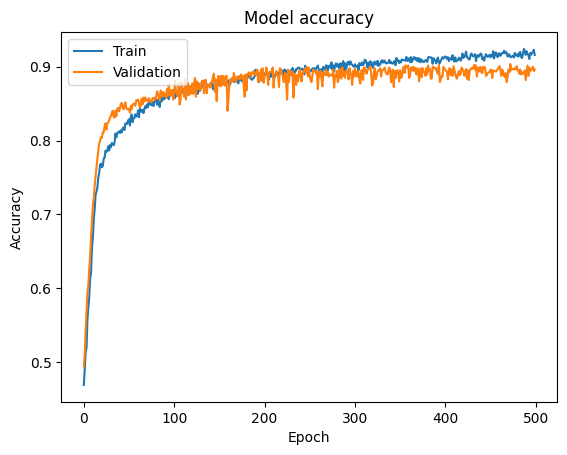

In [8]:
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [9]:
model = load_model('./weight_cp/weight_lstm1.hdf5')
predictions = model.predict(X_test)
predictions = np.where(predictions > 0.5, 1, 0)
y_pred = []
for p in predictions:
    y_pred.append(p[0])
y_pred = np.array(y_pred)
from sklearn.metrics import classification_report, accuracy_score
print("CLASSIFICATION REPORT OF LSTM")
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

CLASSIFICATION REPORT OF LSTM
              precision    recall  f1-score   support

           0       0.85      0.93      0.89       661
           1       0.92      0.84      0.88       662

    accuracy                           0.89      1323
   macro avg       0.89      0.89      0.88      1323
weighted avg       0.89      0.89      0.88      1323

0.8851095993953136


In [10]:
def nlp_lstm2(w2v):
    inputs = Input(shape=(X_train[0].shape[-1],))

    embedding_layer = gensim_to_keras_embedding(w2v)
    
    embedding = embedding_layer(inputs)

    lstm1 = LSTM(lstm_units,return_sequences=True, return_state=True, kernel_regularizer=l2(w_decay),recurrent_regularizer=l2(w_decay), dropout=dropout_rate)(embedding)
    
    
    
    output = Dense(units=1, activation='sigmoid', name='op_main')(lstm1[1])
    

    output_td_gap = GlobalAveragePooling1D(data_format='channels_first')(lstm1[0])
    
    output_td = TimeDistributed(Dense(units=1, activation='sigmoid'))(lstm1[0])
    output_td = Flatten()(output_td)
    
    output_td = Multiply()([output_td_gap, output_td])
    
    output_td = Activation('relu', name='before_split')(output_td)
    
    output_td_splits = tf.split(output_td, 10, axis=-1)
    
    features = concatenate([output_td_splits[0], output_td_splits[1], output_td_splits[-2], output_td_splits[-1]])
    
    print(features.shape)
    
    output_td = Reshape((8, 10, 1))(features)
    
    output_td = Conv2D(2, 8, padding='same', strides=1, activation='relu', kernel_regularizer=l2(w_decay))(output_td)
    output_td = BatchNormalization()(output_td)
    output_td = Flatten()(output_td)
   

    output_td = Dense(units=1, activation='sigmoid', name='op_conv')(output_td)
    
    
    
    avg = tf.keras.layers.Average(name='avg')([output, output_td])
    

    model = Model(inputs, [output, output_td, avg])
    return model


model = nlp_lstm2(w2v_model)



checkpoint = ModelCheckpoint('./weight_cp/weight_lstm2.hdf5', save_freq="epoch",  verbose=1, monitor='val_avg_accuracy', save_best_only=True,
    save_weights_only=False)

metrics = ['accuracy']
optimizer = Adam(0.0001)
model.compile(optimizer = optimizer, loss='binary_crossentropy', metrics=metrics)
model.summary()
history = model.fit(X_train, y_train, epochs=epochs_to_run, validation_data=(X_val, y_val), callbacks=[checkpoint])








(None, 80)
Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 200, 100)     14114800    input_2[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, 200, 10), (N 4440        embedding_1[0][0]                
__________________________________________________________________________________________________
time_distributed (TimeDistribut (None, 200, 1)       11          lstm_1[0][0]                     
____________________________________________________________________________

133/133 [==============================] - 2s 16ms/step - loss: 3.7280 - op_main_loss: 0.6697 - op_conv_loss: 0.6925 - avg_loss: 0.6765 - op_main_accuracy: 0.5903 - op_conv_accuracy: 0.4981 - avg_accuracy: 0.5929 - val_loss: 3.6055 - val_op_main_loss: 0.6592 - val_op_conv_loss: 0.6944 - val_avg_loss: 0.6729 - val_op_main_accuracy: 0.6185 - val_op_conv_accuracy: 0.4910 - val_avg_accuracy: 0.6270
Epoch 7/500
131/133 [============================>.] - ETA: 0s - loss: 3.4997 - op_main_loss: 0.6565 - op_conv_loss: 0.6918 - avg_loss: 0.6695 - op_main_accuracy: 0.6157 - op_conv_accuracy: 0.5167 - avg_accuracy: 0.6217
Epoch 00007: val_avg_accuracy improved from 0.62701 to 0.63834, saving model to ./weight_cp\weight_lstm2.hdf5
133/133 [==============================] - 2s 16ms/step - loss: 3.4991 - op_main_loss: 0.6566 - op_conv_loss: 0.6919 - avg_loss: 0.6696 - op_main_accuracy: 0.6158 - op_conv_accuracy: 0.5163 - avg_accuracy: 0.6215 - val_loss: 3.3964 - val_op_main_loss: 0.6501 - val_op_conv

Epoch 18/500
131/133 [============================>.] - ETA: 0s - loss: 1.9596 - op_main_loss: 0.5481 - op_conv_loss: 0.4563 - avg_loss: 0.4768 - op_main_accuracy: 0.7440 - op_conv_accuracy: 0.7908 - avg_accuracy: 0.8101
Epoch 00018: val_avg_accuracy improved from 0.82625 to 0.82814, saving model to ./weight_cp\weight_lstm2.hdf5
133/133 [==============================] - 2s 16ms/step - loss: 1.9589 - op_main_loss: 0.5481 - op_conv_loss: 0.4558 - avg_loss: 0.4766 - op_main_accuracy: 0.7434 - op_conv_accuracy: 0.7909 - avg_accuracy: 0.8098 - val_loss: 1.8608 - val_op_main_loss: 0.5383 - val_op_conv_loss: 0.4124 - val_avg_loss: 0.4457 - val_op_main_accuracy: 0.7498 - val_op_conv_accuracy: 0.8083 - val_avg_accuracy: 0.8281
Epoch 19/500
130/133 [============================>.] - ETA: 0s - loss: 1.9057 - op_main_loss: 0.5438 - op_conv_loss: 0.4430 - avg_loss: 0.4667 - op_main_accuracy: 0.7466 - op_conv_accuracy: 0.7906 - avg_accuracy: 0.8075
Epoch 00019: val_avg_accuracy did not improve from

Epoch 30/500
129/133 [============================>.] - ETA: 0s - loss: 1.5501 - op_main_loss: 0.4868 - op_conv_loss: 0.3589 - avg_loss: 0.3964 - op_main_accuracy: 0.7863 - op_conv_accuracy: 0.8496 - avg_accuracy: 0.8464
Epoch 00030: val_avg_accuracy did not improve from 0.85741
133/133 [==============================] - 2s 14ms/step - loss: 1.5496 - op_main_loss: 0.4866 - op_conv_loss: 0.3589 - avg_loss: 0.3963 - op_main_accuracy: 0.7876 - op_conv_accuracy: 0.8497 - avg_accuracy: 0.8471 - val_loss: 1.4671 - val_op_main_loss: 0.4672 - val_op_conv_loss: 0.3242 - val_avg_loss: 0.3710 - val_op_main_accuracy: 0.8074 - val_op_conv_accuracy: 0.8546 - val_avg_accuracy: 0.8574
Epoch 31/500
129/133 [============================>.] - ETA: 0s - loss: 1.5363 - op_main_loss: 0.4874 - op_conv_loss: 0.3532 - avg_loss: 0.3939 - op_main_accuracy: 0.7895 - op_conv_accuracy: 0.8462 - avg_accuracy: 0.8508
Epoch 00031: val_avg_accuracy improved from 0.85741 to 0.86213, saving model to ./weight_cp\weight_ls

Epoch 42/500
129/133 [============================>.] - ETA: 0s - loss: 1.3537 - op_main_loss: 0.4379 - op_conv_loss: 0.3085 - avg_loss: 0.3480 - op_main_accuracy: 0.8181 - op_conv_accuracy: 0.8694 - avg_accuracy: 0.8687
Epoch 00042: val_avg_accuracy did not improve from 0.87724
133/133 [==============================] - 2s 14ms/step - loss: 1.3515 - op_main_loss: 0.4373 - op_conv_loss: 0.3075 - avg_loss: 0.3474 - op_main_accuracy: 0.8176 - op_conv_accuracy: 0.8693 - avg_accuracy: 0.8689 - val_loss: 1.3216 - val_op_main_loss: 0.4197 - val_op_conv_loss: 0.3069 - val_avg_loss: 0.3370 - val_op_main_accuracy: 0.8253 - val_op_conv_accuracy: 0.8697 - val_avg_accuracy: 0.8725
Epoch 43/500
130/133 [============================>.] - ETA: 0s - loss: 1.3479 - op_main_loss: 0.4372 - op_conv_loss: 0.3064 - avg_loss: 0.3473 - op_main_accuracy: 0.8168 - op_conv_accuracy: 0.8716 - avg_accuracy: 0.8690
Epoch 00043: val_avg_accuracy did not improve from 0.87724
133/133 [==============================] -

Epoch 54/500
133/133 [==============================] - ETA: 0s - loss: 1.2490 - op_main_loss: 0.4047 - op_conv_loss: 0.2835 - avg_loss: 0.3211 - op_main_accuracy: 0.8306 - op_conv_accuracy: 0.8852 - avg_accuracy: 0.8854
Epoch 00054: val_avg_accuracy did not improve from 0.88952
133/133 [==============================] - 2s 14ms/step - loss: 1.2490 - op_main_loss: 0.4047 - op_conv_loss: 0.2835 - avg_loss: 0.3211 - op_main_accuracy: 0.8306 - op_conv_accuracy: 0.8852 - avg_accuracy: 0.8854 - val_loss: 1.2173 - val_op_main_loss: 0.3874 - val_op_conv_loss: 0.2813 - val_avg_loss: 0.3094 - val_op_main_accuracy: 0.8423 - val_op_conv_accuracy: 0.8886 - val_avg_accuracy: 0.8848
Epoch 55/500
130/133 [============================>.] - ETA: 0s - loss: 1.2285 - op_main_loss: 0.3998 - op_conv_loss: 0.2749 - avg_loss: 0.3152 - op_main_accuracy: 0.8332 - op_conv_accuracy: 0.8877 - avg_accuracy: 0.8873
Epoch 00055: val_avg_accuracy did not improve from 0.88952
133/133 [==============================] -

129/133 [============================>.] - ETA: 0s - loss: 1.1623 - op_main_loss: 0.3754 - op_conv_loss: 0.2607 - avg_loss: 0.2973 - op_main_accuracy: 0.8442 - op_conv_accuracy: 0.8920 - avg_accuracy: 0.8898
Epoch 00066: val_avg_accuracy did not improve from 0.89330
133/133 [==============================] - 2s 14ms/step - loss: 1.1652 - op_main_loss: 0.3765 - op_conv_loss: 0.2617 - avg_loss: 0.2981 - op_main_accuracy: 0.8433 - op_conv_accuracy: 0.8915 - avg_accuracy: 0.8892 - val_loss: 1.1526 - val_op_main_loss: 0.3578 - val_op_conv_loss: 0.2747 - val_avg_loss: 0.2916 - val_op_main_accuracy: 0.8546 - val_op_conv_accuracy: 0.8933 - val_avg_accuracy: 0.8905
Epoch 67/500
129/133 [============================>.] - ETA: 0s - loss: 1.1610 - op_main_loss: 0.3748 - op_conv_loss: 0.2614 - avg_loss: 0.2965 - op_main_accuracy: 0.8459 - op_conv_accuracy: 0.8893 - avg_accuracy: 0.8874
Epoch 00067: val_avg_accuracy did not improve from 0.89330
133/133 [==============================] - 2s 14ms/step

129/133 [============================>.] - ETA: 0s - loss: 1.1129 - op_main_loss: 0.3553 - op_conv_loss: 0.2515 - avg_loss: 0.2841 - op_main_accuracy: 0.8493 - op_conv_accuracy: 0.8951 - avg_accuracy: 0.8963
Epoch 00078: val_avg_accuracy did not improve from 0.89424
133/133 [==============================] - 2s 14ms/step - loss: 1.1162 - op_main_loss: 0.3565 - op_conv_loss: 0.2525 - avg_loss: 0.2851 - op_main_accuracy: 0.8483 - op_conv_accuracy: 0.8946 - avg_accuracy: 0.8956 - val_loss: 1.1179 - val_op_main_loss: 0.3380 - val_op_conv_loss: 0.2741 - val_avg_loss: 0.2842 - val_op_main_accuracy: 0.8640 - val_op_conv_accuracy: 0.8905 - val_avg_accuracy: 0.8876
Epoch 79/500
130/133 [============================>.] - ETA: 0s - loss: 1.1136 - op_main_loss: 0.3581 - op_conv_loss: 0.2488 - avg_loss: 0.2855 - op_main_accuracy: 0.8502 - op_conv_accuracy: 0.8957 - avg_accuracy: 0.8935
Epoch 00079: val_avg_accuracy did not improve from 0.89424
133/133 [==============================] - 2s 14ms/step

132/133 [============================>.] - ETA: 0s - loss: 1.0910 - op_main_loss: 0.3444 - op_conv_loss: 0.2507 - avg_loss: 0.2783 - op_main_accuracy: 0.8558 - op_conv_accuracy: 0.8965 - avg_accuracy: 0.8942
Epoch 00090: val_avg_accuracy did not improve from 0.89802
133/133 [==============================] - 2s 14ms/step - loss: 1.0903 - op_main_loss: 0.3443 - op_conv_loss: 0.2503 - avg_loss: 0.2781 - op_main_accuracy: 0.8561 - op_conv_accuracy: 0.8967 - avg_accuracy: 0.8944 - val_loss: 1.0891 - val_op_main_loss: 0.3218 - val_op_conv_loss: 0.2750 - val_avg_loss: 0.2751 - val_op_main_accuracy: 0.8687 - val_op_conv_accuracy: 0.8952 - val_avg_accuracy: 0.8980
Epoch 91/500
133/133 [==============================] - ETA: 0s - loss: 1.0581 - op_main_loss: 0.3348 - op_conv_loss: 0.2371 - avg_loss: 0.2688 - op_main_accuracy: 0.8632 - op_conv_accuracy: 0.9029 - avg_accuracy: 0.9003
Epoch 00091: val_avg_accuracy did not improve from 0.89802
133/133 [==============================] - 2s 14ms/step

133/133 [==============================] - ETA: 0s - loss: 1.0373 - op_main_loss: 0.3246 - op_conv_loss: 0.2360 - avg_loss: 0.2617 - op_main_accuracy: 0.8637 - op_conv_accuracy: 0.9022 - avg_accuracy: 0.8998
Epoch 00102: val_avg_accuracy did not improve from 0.89802
133/133 [==============================] - 2s 14ms/step - loss: 1.0373 - op_main_loss: 0.3246 - op_conv_loss: 0.2360 - avg_loss: 0.2617 - op_main_accuracy: 0.8637 - op_conv_accuracy: 0.9022 - avg_accuracy: 0.8998 - val_loss: 1.0848 - val_op_main_loss: 0.3095 - val_op_conv_loss: 0.2885 - val_avg_loss: 0.2721 - val_op_main_accuracy: 0.8687 - val_op_conv_accuracy: 0.8895 - val_avg_accuracy: 0.8933
Epoch 103/500
130/133 [============================>.] - ETA: 0s - loss: 1.0286 - op_main_loss: 0.3226 - op_conv_loss: 0.2316 - avg_loss: 0.2597 - op_main_accuracy: 0.8709 - op_conv_accuracy: 0.9046 - avg_accuracy: 0.8978
Epoch 00103: val_avg_accuracy did not improve from 0.89802
133/133 [==============================] - 2s 14ms/ste

130/133 [============================>.] - ETA: 0s - loss: 0.9806 - op_main_loss: 0.3083 - op_conv_loss: 0.2153 - avg_loss: 0.2443 - op_main_accuracy: 0.8714 - op_conv_accuracy: 0.9147 - avg_accuracy: 0.9082
Epoch 00114: val_avg_accuracy did not improve from 0.89802
133/133 [==============================] - 2s 14ms/step - loss: 0.9805 - op_main_loss: 0.3081 - op_conv_loss: 0.2155 - avg_loss: 0.2442 - op_main_accuracy: 0.8715 - op_conv_accuracy: 0.9145 - avg_accuracy: 0.9081 - val_loss: 1.0849 - val_op_main_loss: 0.3025 - val_op_conv_loss: 0.2965 - val_avg_loss: 0.2732 - val_op_main_accuracy: 0.8848 - val_op_conv_accuracy: 0.8876 - val_avg_accuracy: 0.8980
Epoch 115/500
129/133 [============================>.] - ETA: 0s - loss: 0.9647 - op_main_loss: 0.3048 - op_conv_loss: 0.2074 - avg_loss: 0.2400 - op_main_accuracy: 0.8726 - op_conv_accuracy: 0.9164 - avg_accuracy: 0.9079
Epoch 00115: val_avg_accuracy did not improve from 0.89802
133/133 [==============================] - 2s 14ms/ste

Epoch 126/500
131/133 [============================>.] - ETA: 0s - loss: 0.9628 - op_main_loss: 0.2956 - op_conv_loss: 0.2162 - avg_loss: 0.2407 - op_main_accuracy: 0.8841 - op_conv_accuracy: 0.9125 - avg_accuracy: 0.9086
Epoch 00126: val_avg_accuracy did not improve from 0.90085
133/133 [==============================] - 2s 14ms/step - loss: 0.9623 - op_main_loss: 0.2954 - op_conv_loss: 0.2161 - avg_loss: 0.2405 - op_main_accuracy: 0.8845 - op_conv_accuracy: 0.9126 - avg_accuracy: 0.9088 - val_loss: 1.0462 - val_op_main_loss: 0.2942 - val_op_conv_loss: 0.2775 - val_avg_loss: 0.2642 - val_op_main_accuracy: 0.8905 - val_op_conv_accuracy: 0.9037 - val_avg_accuracy: 0.9008
Epoch 127/500
129/133 [============================>.] - ETA: 0s - loss: 0.9604 - op_main_loss: 0.2984 - op_conv_loss: 0.2116 - avg_loss: 0.2401 - op_main_accuracy: 0.8823 - op_conv_accuracy: 0.9104 - avg_accuracy: 0.9072
Epoch 00127: val_avg_accuracy did not improve from 0.90085
133/133 [==============================]

Epoch 138/500
129/133 [============================>.] - ETA: 0s - loss: 0.9385 - op_main_loss: 0.2837 - op_conv_loss: 0.2123 - avg_loss: 0.2335 - op_main_accuracy: 0.8857 - op_conv_accuracy: 0.9145 - avg_accuracy: 0.9128
Epoch 00138: val_avg_accuracy did not improve from 0.90652
133/133 [==============================] - 2s 14ms/step - loss: 0.9408 - op_main_loss: 0.2848 - op_conv_loss: 0.2128 - avg_loss: 0.2342 - op_main_accuracy: 0.8854 - op_conv_accuracy: 0.9140 - avg_accuracy: 0.9119 - val_loss: 1.0353 - val_op_main_loss: 0.2874 - val_op_conv_loss: 0.2765 - val_avg_loss: 0.2624 - val_op_main_accuracy: 0.8905 - val_op_conv_accuracy: 0.9027 - val_avg_accuracy: 0.9018
Epoch 139/500
132/133 [============================>.] - ETA: 0s - loss: 0.9227 - op_main_loss: 0.2824 - op_conv_loss: 0.2033 - avg_loss: 0.2282 - op_main_accuracy: 0.8913 - op_conv_accuracy: 0.9216 - avg_accuracy: 0.9197
Epoch 00139: val_avg_accuracy did not improve from 0.90652
133/133 [==============================]

130/133 [============================>.] - ETA: 0s - loss: 0.9015 - op_main_loss: 0.2727 - op_conv_loss: 0.1984 - avg_loss: 0.2220 - op_main_accuracy: 0.8964 - op_conv_accuracy: 0.9195 - avg_accuracy: 0.9163
Epoch 00150: val_avg_accuracy did not improve from 0.90652
133/133 [==============================] - 2s 14ms/step - loss: 0.8985 - op_main_loss: 0.2715 - op_conv_loss: 0.1975 - avg_loss: 0.2211 - op_main_accuracy: 0.8977 - op_conv_accuracy: 0.9201 - avg_accuracy: 0.9168 - val_loss: 1.0628 - val_op_main_loss: 0.2877 - val_op_conv_loss: 0.2999 - val_avg_loss: 0.2670 - val_op_main_accuracy: 0.8914 - val_op_conv_accuracy: 0.8933 - val_avg_accuracy: 0.8990
Epoch 151/500
129/133 [============================>.] - ETA: 0s - loss: 0.9125 - op_main_loss: 0.2735 - op_conv_loss: 0.2059 - avg_loss: 0.2252 - op_main_accuracy: 0.8961 - op_conv_accuracy: 0.9145 - avg_accuracy: 0.9140
Epoch 00151: val_avg_accuracy did not improve from 0.90652
133/133 [==============================] - 2s 14ms/ste

129/133 [============================>.] - ETA: 0s - loss: 0.8764 - op_main_loss: 0.2655 - op_conv_loss: 0.1899 - avg_loss: 0.2154 - op_main_accuracy: 0.8987 - op_conv_accuracy: 0.9237 - avg_accuracy: 0.9215
Epoch 00162: val_avg_accuracy did not improve from 0.90652
133/133 [==============================] - 2s 14ms/step - loss: 0.8761 - op_main_loss: 0.2653 - op_conv_loss: 0.1898 - avg_loss: 0.2153 - op_main_accuracy: 0.8991 - op_conv_accuracy: 0.9232 - avg_accuracy: 0.9213 - val_loss: 1.0380 - val_op_main_loss: 0.2808 - val_op_conv_loss: 0.2909 - val_avg_loss: 0.2606 - val_op_main_accuracy: 0.8933 - val_op_conv_accuracy: 0.8971 - val_avg_accuracy: 0.9027
Epoch 163/500
129/133 [============================>.] - ETA: 0s - loss: 0.8975 - op_main_loss: 0.2678 - op_conv_loss: 0.2018 - avg_loss: 0.2223 - op_main_accuracy: 0.8929 - op_conv_accuracy: 0.9174 - avg_accuracy: 0.9164
Epoch 00163: val_avg_accuracy did not improve from 0.90652
133/133 [==============================] - 2s 14ms/ste

131/133 [============================>.] - ETA: 0s - loss: 0.8774 - op_main_loss: 0.2622 - op_conv_loss: 0.1954 - avg_loss: 0.2158 - op_main_accuracy: 0.8989 - op_conv_accuracy: 0.9215 - avg_accuracy: 0.9222
Epoch 00174: val_avg_accuracy did not improve from 0.90652
133/133 [==============================] - 2s 14ms/step - loss: 0.8792 - op_main_loss: 0.2629 - op_conv_loss: 0.1960 - avg_loss: 0.2164 - op_main_accuracy: 0.8984 - op_conv_accuracy: 0.9213 - avg_accuracy: 0.9218 - val_loss: 1.0292 - val_op_main_loss: 0.2786 - val_op_conv_loss: 0.2865 - val_avg_loss: 0.2603 - val_op_main_accuracy: 0.8942 - val_op_conv_accuracy: 0.8924 - val_avg_accuracy: 0.8999
Epoch 175/500
130/133 [============================>.] - ETA: 0s - loss: 0.8651 - op_main_loss: 0.2591 - op_conv_loss: 0.1895 - avg_loss: 0.2129 - op_main_accuracy: 0.8935 - op_conv_accuracy: 0.9216 - avg_accuracy: 0.9190
Epoch 00175: val_avg_accuracy did not improve from 0.90652
133/133 [==============================] - 2s 14ms/ste

129/133 [============================>.] - ETA: 0s - loss: 0.8502 - op_main_loss: 0.2559 - op_conv_loss: 0.1845 - avg_loss: 0.2078 - op_main_accuracy: 0.9012 - op_conv_accuracy: 0.9278 - avg_accuracy: 0.9234
Epoch 00186: val_avg_accuracy did not improve from 0.91124
133/133 [==============================] - 2s 14ms/step - loss: 0.8496 - op_main_loss: 0.2561 - op_conv_loss: 0.1839 - avg_loss: 0.2076 - op_main_accuracy: 0.9003 - op_conv_accuracy: 0.9279 - avg_accuracy: 0.9232 - val_loss: 1.0210 - val_op_main_loss: 0.2799 - val_op_conv_loss: 0.2769 - val_avg_loss: 0.2623 - val_op_main_accuracy: 0.8914 - val_op_conv_accuracy: 0.9008 - val_avg_accuracy: 0.8980
Epoch 187/500
131/133 [============================>.] - ETA: 0s - loss: 0.8636 - op_main_loss: 0.2592 - op_conv_loss: 0.1897 - avg_loss: 0.2125 - op_main_accuracy: 0.8989 - op_conv_accuracy: 0.9220 - avg_accuracy: 0.9196
Epoch 00187: val_avg_accuracy did not improve from 0.91124
133/133 [==============================] - 2s 14ms/ste

129/133 [============================>.] - ETA: 0s - loss: 0.8285 - op_main_loss: 0.2488 - op_conv_loss: 0.1764 - avg_loss: 0.2024 - op_main_accuracy: 0.9046 - op_conv_accuracy: 0.9271 - avg_accuracy: 0.9254
Epoch 00198: val_avg_accuracy did not improve from 0.91124
133/133 [==============================] - 2s 14ms/step - loss: 0.8284 - op_main_loss: 0.2481 - op_conv_loss: 0.1770 - avg_loss: 0.2024 - op_main_accuracy: 0.9050 - op_conv_accuracy: 0.9263 - avg_accuracy: 0.9251 - val_loss: 1.0165 - val_op_main_loss: 0.2705 - val_op_conv_loss: 0.2895 - val_avg_loss: 0.2557 - val_op_main_accuracy: 0.8971 - val_op_conv_accuracy: 0.9056 - val_avg_accuracy: 0.9065
Epoch 199/500
129/133 [============================>.] - ETA: 0s - loss: 0.8140 - op_main_loss: 0.2418 - op_conv_loss: 0.1744 - avg_loss: 0.1971 - op_main_accuracy: 0.9075 - op_conv_accuracy: 0.9283 - avg_accuracy: 0.9276
Epoch 00199: val_avg_accuracy did not improve from 0.91124
133/133 [==============================] - 2s 14ms/ste

130/133 [============================>.] - ETA: 0s - loss: 0.8226 - op_main_loss: 0.2457 - op_conv_loss: 0.1766 - avg_loss: 0.2002 - op_main_accuracy: 0.9067 - op_conv_accuracy: 0.9279 - avg_accuracy: 0.9276
Epoch 00210: val_avg_accuracy did not improve from 0.91124
133/133 [==============================] - 2s 14ms/step - loss: 0.8277 - op_main_loss: 0.2473 - op_conv_loss: 0.1785 - avg_loss: 0.2018 - op_main_accuracy: 0.9060 - op_conv_accuracy: 0.9270 - avg_accuracy: 0.9267 - val_loss: 1.0068 - val_op_main_loss: 0.2701 - val_op_conv_loss: 0.2814 - val_avg_loss: 0.2554 - val_op_main_accuracy: 0.8980 - val_op_conv_accuracy: 0.9008 - val_avg_accuracy: 0.9056
Epoch 211/500
131/133 [============================>.] - ETA: 0s - loss: 0.8092 - op_main_loss: 0.2385 - op_conv_loss: 0.1751 - avg_loss: 0.1959 - op_main_accuracy: 0.9086 - op_conv_accuracy: 0.9301 - avg_accuracy: 0.9256
Epoch 00211: val_avg_accuracy did not improve from 0.91124
133/133 [==============================] - 2s 14ms/ste

129/133 [============================>.] - ETA: 0s - loss: 0.8165 - op_main_loss: 0.2425 - op_conv_loss: 0.1765 - avg_loss: 0.1991 - op_main_accuracy: 0.9062 - op_conv_accuracy: 0.9300 - avg_accuracy: 0.9276
Epoch 00222: val_avg_accuracy did not improve from 0.91124
133/133 [==============================] - 2s 14ms/step - loss: 0.8122 - op_main_loss: 0.2409 - op_conv_loss: 0.1751 - avg_loss: 0.1977 - op_main_accuracy: 0.9071 - op_conv_accuracy: 0.9303 - avg_accuracy: 0.9284 - val_loss: 1.0066 - val_op_main_loss: 0.2694 - val_op_conv_loss: 0.2842 - val_avg_loss: 0.2541 - val_op_main_accuracy: 0.8961 - val_op_conv_accuracy: 0.8952 - val_avg_accuracy: 0.9065
Epoch 223/500
129/133 [============================>.] - ETA: 0s - loss: 0.7974 - op_main_loss: 0.2350 - op_conv_loss: 0.1711 - avg_loss: 0.1925 - op_main_accuracy: 0.9121 - op_conv_accuracy: 0.9317 - avg_accuracy: 0.9307
Epoch 00223: val_avg_accuracy did not improve from 0.91124
133/133 [==============================] - 2s 14ms/ste

132/133 [============================>.] - ETA: 0s - loss: 0.7994 - op_main_loss: 0.2346 - op_conv_loss: 0.1738 - avg_loss: 0.1933 - op_main_accuracy: 0.9157 - op_conv_accuracy: 0.9285 - avg_accuracy: 0.9290
Epoch 00234: val_avg_accuracy did not improve from 0.91124
133/133 [==============================] - 2s 14ms/step - loss: 0.7985 - op_main_loss: 0.2342 - op_conv_loss: 0.1735 - avg_loss: 0.1930 - op_main_accuracy: 0.9159 - op_conv_accuracy: 0.9286 - avg_accuracy: 0.9291 - val_loss: 0.9970 - val_op_main_loss: 0.2647 - val_op_conv_loss: 0.2832 - val_avg_loss: 0.2515 - val_op_main_accuracy: 0.8971 - val_op_conv_accuracy: 0.9018 - val_avg_accuracy: 0.9056
Epoch 235/500
130/133 [============================>.] - ETA: 0s - loss: 0.7830 - op_main_loss: 0.2296 - op_conv_loss: 0.1675 - avg_loss: 0.1881 - op_main_accuracy: 0.9120 - op_conv_accuracy: 0.9346 - avg_accuracy: 0.9310
Epoch 00235: val_avg_accuracy did not improve from 0.91124
133/133 [==============================] - 2s 14ms/ste

132/133 [============================>.] - ETA: 0s - loss: 0.7942 - op_main_loss: 0.2336 - op_conv_loss: 0.1717 - avg_loss: 0.1924 - op_main_accuracy: 0.9086 - op_conv_accuracy: 0.9297 - avg_accuracy: 0.9278
Epoch 00246: val_avg_accuracy did not improve from 0.91124
133/133 [==============================] - 2s 14ms/step - loss: 0.7938 - op_main_loss: 0.2335 - op_conv_loss: 0.1716 - avg_loss: 0.1923 - op_main_accuracy: 0.9088 - op_conv_accuracy: 0.9296 - avg_accuracy: 0.9277 - val_loss: 1.0114 - val_op_main_loss: 0.2711 - val_op_conv_loss: 0.2867 - val_avg_loss: 0.2573 - val_op_main_accuracy: 0.8971 - val_op_conv_accuracy: 0.9018 - val_avg_accuracy: 0.9037
Epoch 247/500
130/133 [============================>.] - ETA: 0s - loss: 0.7719 - op_main_loss: 0.2290 - op_conv_loss: 0.1611 - avg_loss: 0.1854 - op_main_accuracy: 0.9130 - op_conv_accuracy: 0.9346 - avg_accuracy: 0.9308
Epoch 00247: val_avg_accuracy did not improve from 0.91124
133/133 [==============================] - 2s 14ms/ste

130/133 [============================>.] - ETA: 0s - loss: 0.7855 - op_main_loss: 0.2319 - op_conv_loss: 0.1689 - avg_loss: 0.1889 - op_main_accuracy: 0.9118 - op_conv_accuracy: 0.9325 - avg_accuracy: 0.9293
Epoch 00258: val_avg_accuracy did not improve from 0.91124
133/133 [==============================] - 2s 14ms/step - loss: 0.7830 - op_main_loss: 0.2311 - op_conv_loss: 0.1679 - avg_loss: 0.1881 - op_main_accuracy: 0.9126 - op_conv_accuracy: 0.9327 - avg_accuracy: 0.9296 - val_loss: 1.0575 - val_op_main_loss: 0.2743 - val_op_conv_loss: 0.3170 - val_avg_loss: 0.2705 - val_op_main_accuracy: 0.8961 - val_op_conv_accuracy: 0.8876 - val_avg_accuracy: 0.8961
Epoch 259/500
130/133 [============================>.] - ETA: 0s - loss: 0.7651 - op_main_loss: 0.2290 - op_conv_loss: 0.1575 - avg_loss: 0.1827 - op_main_accuracy: 0.9087 - op_conv_accuracy: 0.9377 - avg_accuracy: 0.9337
Epoch 00259: val_avg_accuracy did not improve from 0.91124
133/133 [==============================] - 2s 14ms/ste

129/133 [============================>.] - ETA: 0s - loss: 0.7599 - op_main_loss: 0.2235 - op_conv_loss: 0.1598 - avg_loss: 0.1813 - op_main_accuracy: 0.9113 - op_conv_accuracy: 0.9339 - avg_accuracy: 0.9297
Epoch 00270: val_avg_accuracy did not improve from 0.91124
133/133 [==============================] - 2s 14ms/step - loss: 0.7601 - op_main_loss: 0.2234 - op_conv_loss: 0.1600 - avg_loss: 0.1814 - op_main_accuracy: 0.9116 - op_conv_accuracy: 0.9336 - avg_accuracy: 0.9293 - val_loss: 1.0270 - val_op_main_loss: 0.2687 - val_op_conv_loss: 0.3022 - val_avg_loss: 0.2610 - val_op_main_accuracy: 0.8990 - val_op_conv_accuracy: 0.8952 - val_avg_accuracy: 0.8990
Epoch 271/500
132/133 [============================>.] - ETA: 0s - loss: 0.7649 - op_main_loss: 0.2239 - op_conv_loss: 0.1628 - avg_loss: 0.1834 - op_main_accuracy: 0.9174 - op_conv_accuracy: 0.9316 - avg_accuracy: 0.9309
Epoch 00271: val_avg_accuracy did not improve from 0.91124
133/133 [==============================] - 2s 14ms/ste

130/133 [============================>.] - ETA: 0s - loss: 0.7263 - op_main_loss: 0.2136 - op_conv_loss: 0.1471 - avg_loss: 0.1708 - op_main_accuracy: 0.9264 - op_conv_accuracy: 0.9421 - avg_accuracy: 0.9385
Epoch 00282: val_avg_accuracy did not improve from 0.91124
133/133 [==============================] - 2s 14ms/step - loss: 0.7228 - op_main_loss: 0.2123 - op_conv_loss: 0.1460 - avg_loss: 0.1697 - op_main_accuracy: 0.9275 - op_conv_accuracy: 0.9426 - avg_accuracy: 0.9393 - val_loss: 1.0079 - val_op_main_loss: 0.2628 - val_op_conv_loss: 0.2965 - val_avg_loss: 0.2538 - val_op_main_accuracy: 0.8980 - val_op_conv_accuracy: 0.9018 - val_avg_accuracy: 0.9065
Epoch 283/500
129/133 [============================>.] - ETA: 0s - loss: 0.7601 - op_main_loss: 0.2236 - op_conv_loss: 0.1610 - avg_loss: 0.1809 - op_main_accuracy: 0.9164 - op_conv_accuracy: 0.9346 - avg_accuracy: 0.9307
Epoch 00283: val_avg_accuracy did not improve from 0.91124
133/133 [==============================] - 2s 14ms/ste

130/133 [============================>.] - ETA: 0s - loss: 0.7484 - op_main_loss: 0.2166 - op_conv_loss: 0.1595 - avg_loss: 0.1789 - op_main_accuracy: 0.9197 - op_conv_accuracy: 0.9361 - avg_accuracy: 0.9312
Epoch 00294: val_avg_accuracy did not improve from 0.91124
133/133 [==============================] - 2s 14ms/step - loss: 0.7483 - op_main_loss: 0.2169 - op_conv_loss: 0.1591 - avg_loss: 0.1789 - op_main_accuracy: 0.9190 - op_conv_accuracy: 0.9360 - avg_accuracy: 0.9310 - val_loss: 1.0111 - val_op_main_loss: 0.2625 - val_op_conv_loss: 0.3016 - val_avg_loss: 0.2539 - val_op_main_accuracy: 0.9018 - val_op_conv_accuracy: 0.9075 - val_avg_accuracy: 0.9037
Epoch 295/500
133/133 [==============================] - ETA: 0s - loss: 0.7599 - op_main_loss: 0.2201 - op_conv_loss: 0.1651 - avg_loss: 0.1821 - op_main_accuracy: 0.9152 - op_conv_accuracy: 0.9327 - avg_accuracy: 0.9317
Epoch 00295: val_avg_accuracy did not improve from 0.91124
133/133 [==============================] - 2s 14ms/ste

130/133 [============================>.] - ETA: 0s - loss: 0.7339 - op_main_loss: 0.2170 - op_conv_loss: 0.1507 - avg_loss: 0.1742 - op_main_accuracy: 0.9180 - op_conv_accuracy: 0.9409 - avg_accuracy: 0.9346
Epoch 00306: val_avg_accuracy did not improve from 0.91124
133/133 [==============================] - 2s 14ms/step - loss: 0.7367 - op_main_loss: 0.2175 - op_conv_loss: 0.1520 - avg_loss: 0.1751 - op_main_accuracy: 0.9182 - op_conv_accuracy: 0.9405 - avg_accuracy: 0.9343 - val_loss: 1.0184 - val_op_main_loss: 0.2660 - val_op_conv_loss: 0.3001 - val_avg_loss: 0.2602 - val_op_main_accuracy: 0.8980 - val_op_conv_accuracy: 0.8952 - val_avg_accuracy: 0.8952
Epoch 307/500
131/133 [============================>.] - ETA: 0s - loss: 0.7408 - op_main_loss: 0.2173 - op_conv_loss: 0.1552 - avg_loss: 0.1764 - op_main_accuracy: 0.9163 - op_conv_accuracy: 0.9392 - avg_accuracy: 0.9368
Epoch 00307: val_avg_accuracy did not improve from 0.91124
133/133 [==============================] - 2s 14ms/ste

131/133 [============================>.] - ETA: 0s - loss: 0.7317 - op_main_loss: 0.2132 - op_conv_loss: 0.1534 - avg_loss: 0.1736 - op_main_accuracy: 0.9158 - op_conv_accuracy: 0.9396 - avg_accuracy: 0.9334
Epoch 00318: val_avg_accuracy did not improve from 0.91124
133/133 [==============================] - 2s 14ms/step - loss: 0.7305 - op_main_loss: 0.2127 - op_conv_loss: 0.1532 - avg_loss: 0.1732 - op_main_accuracy: 0.9164 - op_conv_accuracy: 0.9395 - avg_accuracy: 0.9336 - val_loss: 1.0101 - val_op_main_loss: 0.2611 - val_op_conv_loss: 0.3025 - val_avg_loss: 0.2551 - val_op_main_accuracy: 0.8999 - val_op_conv_accuracy: 0.9046 - val_avg_accuracy: 0.8999
Epoch 319/500
129/133 [============================>.] - ETA: 0s - loss: 0.7398 - op_main_loss: 0.2137 - op_conv_loss: 0.1589 - avg_loss: 0.1759 - op_main_accuracy: 0.9215 - op_conv_accuracy: 0.9370 - avg_accuracy: 0.9351
Epoch 00319: val_avg_accuracy did not improve from 0.91124
133/133 [==============================] - 2s 14ms/ste

132/133 [============================>.] - ETA: 0s - loss: 0.7080 - op_main_loss: 0.2062 - op_conv_loss: 0.1451 - avg_loss: 0.1654 - op_main_accuracy: 0.9181 - op_conv_accuracy: 0.9432 - avg_accuracy: 0.9415
Epoch 00330: val_avg_accuracy did not improve from 0.91218
133/133 [==============================] - 2s 14ms/step - loss: 0.7079 - op_main_loss: 0.2063 - op_conv_loss: 0.1450 - avg_loss: 0.1654 - op_main_accuracy: 0.9182 - op_conv_accuracy: 0.9433 - avg_accuracy: 0.9416 - val_loss: 1.0348 - val_op_main_loss: 0.2595 - val_op_conv_loss: 0.3250 - val_avg_loss: 0.2591 - val_op_main_accuracy: 0.9027 - val_op_conv_accuracy: 0.8924 - val_avg_accuracy: 0.8971
Epoch 331/500
129/133 [============================>.] - ETA: 0s - loss: 0.7303 - op_main_loss: 0.2126 - op_conv_loss: 0.1535 - avg_loss: 0.1731 - op_main_accuracy: 0.9164 - op_conv_accuracy: 0.9406 - avg_accuracy: 0.9373
Epoch 00331: val_avg_accuracy did not improve from 0.91218
133/133 [==============================] - 2s 14ms/ste

133/133 [==============================] - ETA: 0s - loss: 0.6958 - op_main_loss: 0.2017 - op_conv_loss: 0.1410 - avg_loss: 0.1630 - op_main_accuracy: 0.9284 - op_conv_accuracy: 0.9459 - avg_accuracy: 0.9480
Epoch 00342: val_avg_accuracy did not improve from 0.91218
133/133 [==============================] - 2s 14ms/step - loss: 0.6958 - op_main_loss: 0.2017 - op_conv_loss: 0.1410 - avg_loss: 0.1630 - op_main_accuracy: 0.9284 - op_conv_accuracy: 0.9459 - avg_accuracy: 0.9480 - val_loss: 1.0244 - val_op_main_loss: 0.2620 - val_op_conv_loss: 0.3114 - val_avg_loss: 0.2609 - val_op_main_accuracy: 0.9027 - val_op_conv_accuracy: 0.8990 - val_avg_accuracy: 0.8980
Epoch 343/500
133/133 [==============================] - ETA: 0s - loss: 0.7011 - op_main_loss: 0.2039 - op_conv_loss: 0.1424 - avg_loss: 0.1647 - op_main_accuracy: 0.9227 - op_conv_accuracy: 0.9421 - avg_accuracy: 0.9409
Epoch 00343: val_avg_accuracy did not improve from 0.91218
133/133 [==============================] - 2s 14ms/ste

129/133 [============================>.] - ETA: 0s - loss: 0.6920 - op_main_loss: 0.1997 - op_conv_loss: 0.1410 - avg_loss: 0.1614 - op_main_accuracy: 0.9232 - op_conv_accuracy: 0.9416 - avg_accuracy: 0.9392
Epoch 00354: val_avg_accuracy did not improve from 0.91218
133/133 [==============================] - 2s 14ms/step - loss: 0.6944 - op_main_loss: 0.2008 - op_conv_loss: 0.1415 - avg_loss: 0.1622 - op_main_accuracy: 0.9227 - op_conv_accuracy: 0.9419 - avg_accuracy: 0.9395 - val_loss: 1.0300 - val_op_main_loss: 0.2636 - val_op_conv_loss: 0.3137 - val_avg_loss: 0.2627 - val_op_main_accuracy: 0.9018 - val_op_conv_accuracy: 0.8980 - val_avg_accuracy: 0.9037
Epoch 355/500
131/133 [============================>.] - ETA: 0s - loss: 0.7329 - op_main_loss: 0.2109 - op_conv_loss: 0.1582 - avg_loss: 0.1737 - op_main_accuracy: 0.9194 - op_conv_accuracy: 0.9404 - avg_accuracy: 0.9358
Epoch 00355: val_avg_accuracy did not improve from 0.91218
133/133 [==============================] - 2s 14ms/ste

131/133 [============================>.] - ETA: 0s - loss: 0.6747 - op_main_loss: 0.1953 - op_conv_loss: 0.1335 - avg_loss: 0.1564 - op_main_accuracy: 0.9342 - op_conv_accuracy: 0.9451 - avg_accuracy: 0.9456
Epoch 00366: val_avg_accuracy did not improve from 0.91218
133/133 [==============================] - 2s 14ms/step - loss: 0.6733 - op_main_loss: 0.1948 - op_conv_loss: 0.1330 - avg_loss: 0.1559 - op_main_accuracy: 0.9343 - op_conv_accuracy: 0.9452 - avg_accuracy: 0.9457 - val_loss: 1.0028 - val_op_main_loss: 0.2569 - val_op_conv_loss: 0.3025 - val_avg_loss: 0.2541 - val_op_main_accuracy: 0.9075 - val_op_conv_accuracy: 0.9027 - val_avg_accuracy: 0.9037
Epoch 367/500
129/133 [============================>.] - ETA: 0s - loss: 0.7013 - op_main_loss: 0.2043 - op_conv_loss: 0.1429 - avg_loss: 0.1646 - op_main_accuracy: 0.9254 - op_conv_accuracy: 0.9409 - avg_accuracy: 0.9416
Epoch 00367: val_avg_accuracy did not improve from 0.91218
133/133 [==============================] - 2s 14ms/ste

131/133 [============================>.] - ETA: 0s - loss: 0.6882 - op_main_loss: 0.1972 - op_conv_loss: 0.1420 - avg_loss: 0.1601 - op_main_accuracy: 0.9303 - op_conv_accuracy: 0.9447 - avg_accuracy: 0.9432
Epoch 00378: val_avg_accuracy did not improve from 0.91218
133/133 [==============================] - 2s 14ms/step - loss: 0.6880 - op_main_loss: 0.1973 - op_conv_loss: 0.1418 - avg_loss: 0.1600 - op_main_accuracy: 0.9301 - op_conv_accuracy: 0.9449 - avg_accuracy: 0.9435 - val_loss: 1.0360 - val_op_main_loss: 0.2632 - val_op_conv_loss: 0.3202 - val_avg_loss: 0.2638 - val_op_main_accuracy: 0.9018 - val_op_conv_accuracy: 0.8980 - val_avg_accuracy: 0.8961
Epoch 379/500
131/133 [============================>.] - ETA: 0s - loss: 0.7050 - op_main_loss: 0.2078 - op_conv_loss: 0.1425 - avg_loss: 0.1660 - op_main_accuracy: 0.9232 - op_conv_accuracy: 0.9416 - avg_accuracy: 0.9389
Epoch 00379: val_avg_accuracy did not improve from 0.91218
133/133 [==============================] - 2s 14ms/ste

129/133 [============================>.] - ETA: 0s - loss: 0.6772 - op_main_loss: 0.1923 - op_conv_loss: 0.1397 - avg_loss: 0.1566 - op_main_accuracy: 0.9339 - op_conv_accuracy: 0.9477 - avg_accuracy: 0.9469
Epoch 00390: val_avg_accuracy did not improve from 0.91218
133/133 [==============================] - 2s 14ms/step - loss: 0.6804 - op_main_loss: 0.1936 - op_conv_loss: 0.1407 - avg_loss: 0.1576 - op_main_accuracy: 0.9329 - op_conv_accuracy: 0.9471 - avg_accuracy: 0.9464 - val_loss: 1.0201 - val_op_main_loss: 0.2573 - val_op_conv_loss: 0.3170 - val_avg_loss: 0.2575 - val_op_main_accuracy: 0.9008 - val_op_conv_accuracy: 0.9037 - val_avg_accuracy: 0.9027
Epoch 391/500
131/133 [============================>.] - ETA: 0s - loss: 0.6683 - op_main_loss: 0.1937 - op_conv_loss: 0.1325 - avg_loss: 0.1541 - op_main_accuracy: 0.9232 - op_conv_accuracy: 0.9449 - avg_accuracy: 0.9439
Epoch 00391: val_avg_accuracy did not improve from 0.91218
133/133 [==============================] - 2s 14ms/ste

129/133 [============================>.] - ETA: 0s - loss: 0.6708 - op_main_loss: 0.1910 - op_conv_loss: 0.1371 - avg_loss: 0.1556 - op_main_accuracy: 0.9302 - op_conv_accuracy: 0.9436 - avg_accuracy: 0.9436
Epoch 00402: val_avg_accuracy did not improve from 0.91218
133/133 [==============================] - 2s 14ms/step - loss: 0.6687 - op_main_loss: 0.1900 - op_conv_loss: 0.1366 - avg_loss: 0.1550 - op_main_accuracy: 0.9305 - op_conv_accuracy: 0.9433 - avg_accuracy: 0.9435 - val_loss: 1.0310 - val_op_main_loss: 0.2626 - val_op_conv_loss: 0.3186 - val_avg_loss: 0.2624 - val_op_main_accuracy: 0.9027 - val_op_conv_accuracy: 0.9008 - val_avg_accuracy: 0.8990
Epoch 403/500
129/133 [============================>.] - ETA: 0s - loss: 0.6665 - op_main_loss: 0.1924 - op_conv_loss: 0.1329 - avg_loss: 0.1538 - op_main_accuracy: 0.9273 - op_conv_accuracy: 0.9482 - avg_accuracy: 0.9443
Epoch 00403: val_avg_accuracy did not improve from 0.91218
133/133 [==============================] - 2s 14ms/ste

132/133 [============================>.] - ETA: 0s - loss: 0.7047 - op_main_loss: 0.2053 - op_conv_loss: 0.1468 - avg_loss: 0.1657 - op_main_accuracy: 0.9228 - op_conv_accuracy: 0.9427 - avg_accuracy: 0.9399
Epoch 00414: val_avg_accuracy did not improve from 0.91218
133/133 [==============================] - 2s 14ms/step - loss: 0.7038 - op_main_loss: 0.2049 - op_conv_loss: 0.1466 - avg_loss: 0.1654 - op_main_accuracy: 0.9230 - op_conv_accuracy: 0.9428 - avg_accuracy: 0.9400 - val_loss: 1.0103 - val_op_main_loss: 0.2586 - val_op_conv_loss: 0.3100 - val_avg_loss: 0.2550 - val_op_main_accuracy: 0.8971 - val_op_conv_accuracy: 0.9027 - val_avg_accuracy: 0.9037
Epoch 415/500
131/133 [============================>.] - ETA: 0s - loss: 0.6833 - op_main_loss: 0.1996 - op_conv_loss: 0.1381 - avg_loss: 0.1591 - op_main_accuracy: 0.9237 - op_conv_accuracy: 0.9475 - avg_accuracy: 0.9439
Epoch 00415: val_avg_accuracy did not improve from 0.91218
133/133 [==============================] - 2s 14ms/ste

130/133 [============================>.] - ETA: 0s - loss: 0.6465 - op_main_loss: 0.1853 - op_conv_loss: 0.1276 - avg_loss: 0.1474 - op_main_accuracy: 0.9356 - op_conv_accuracy: 0.9481 - avg_accuracy: 0.9478
Epoch 00426: val_avg_accuracy did not improve from 0.91218
133/133 [==============================] - 2s 14ms/step - loss: 0.6506 - op_main_loss: 0.1860 - op_conv_loss: 0.1299 - avg_loss: 0.1485 - op_main_accuracy: 0.9357 - op_conv_accuracy: 0.9473 - avg_accuracy: 0.9475 - val_loss: 1.0187 - val_op_main_loss: 0.2546 - val_op_conv_loss: 0.3227 - val_avg_loss: 0.2551 - val_op_main_accuracy: 0.9046 - val_op_conv_accuracy: 0.9018 - val_avg_accuracy: 0.9046
Epoch 427/500
129/133 [============================>.] - ETA: 0s - loss: 0.6581 - op_main_loss: 0.1895 - op_conv_loss: 0.1306 - avg_loss: 0.1516 - op_main_accuracy: 0.9310 - op_conv_accuracy: 0.9511 - avg_accuracy: 0.9469
Epoch 00427: val_avg_accuracy did not improve from 0.91218
133/133 [==============================] - 2s 14ms/ste

131/133 [============================>.] - ETA: 0s - loss: 0.6655 - op_main_loss: 0.1907 - op_conv_loss: 0.1351 - avg_loss: 0.1536 - op_main_accuracy: 0.9296 - op_conv_accuracy: 0.9435 - avg_accuracy: 0.9430
Epoch 00438: val_avg_accuracy did not improve from 0.91218
133/133 [==============================] - 2s 14ms/step - loss: 0.6655 - op_main_loss: 0.1905 - op_conv_loss: 0.1353 - avg_loss: 0.1536 - op_main_accuracy: 0.9301 - op_conv_accuracy: 0.9435 - avg_accuracy: 0.9431 - val_loss: 1.0204 - val_op_main_loss: 0.2606 - val_op_conv_loss: 0.3142 - val_avg_loss: 0.2596 - val_op_main_accuracy: 0.9037 - val_op_conv_accuracy: 0.9027 - val_avg_accuracy: 0.9075
Epoch 439/500
131/133 [============================>.] - ETA: 0s - loss: 0.6763 - op_main_loss: 0.1942 - op_conv_loss: 0.1390 - avg_loss: 0.1574 - op_main_accuracy: 0.9287 - op_conv_accuracy: 0.9461 - avg_accuracy: 0.9447
Epoch 00439: val_avg_accuracy did not improve from 0.91218
133/133 [==============================] - 2s 14ms/ste

131/133 [============================>.] - ETA: 0s - loss: 0.6558 - op_main_loss: 0.1857 - op_conv_loss: 0.1343 - avg_loss: 0.1502 - op_main_accuracy: 0.9315 - op_conv_accuracy: 0.9461 - avg_accuracy: 0.9449
Epoch 00450: val_avg_accuracy did not improve from 0.91218
133/133 [==============================] - 2s 14ms/step - loss: 0.6545 - op_main_loss: 0.1855 - op_conv_loss: 0.1336 - avg_loss: 0.1498 - op_main_accuracy: 0.9312 - op_conv_accuracy: 0.9464 - avg_accuracy: 0.9452 - val_loss: 0.9941 - val_op_main_loss: 0.2554 - val_op_conv_loss: 0.3008 - val_avg_loss: 0.2523 - val_op_main_accuracy: 0.9046 - val_op_conv_accuracy: 0.9046 - val_avg_accuracy: 0.9046
Epoch 451/500
133/133 [==============================] - ETA: 0s - loss: 0.6819 - op_main_loss: 0.1960 - op_conv_loss: 0.1418 - avg_loss: 0.1583 - op_main_accuracy: 0.9270 - op_conv_accuracy: 0.9445 - avg_accuracy: 0.9426
Epoch 00451: val_avg_accuracy did not improve from 0.91218
133/133 [==============================] - 2s 14ms/ste

131/133 [============================>.] - ETA: 0s - loss: 0.6606 - op_main_loss: 0.1886 - op_conv_loss: 0.1342 - avg_loss: 0.1522 - op_main_accuracy: 0.9318 - op_conv_accuracy: 0.9466 - avg_accuracy: 0.9442
Epoch 00462: val_avg_accuracy did not improve from 0.91218
133/133 [==============================] - 2s 12ms/step - loss: 0.6598 - op_main_loss: 0.1882 - op_conv_loss: 0.1341 - avg_loss: 0.1519 - op_main_accuracy: 0.9319 - op_conv_accuracy: 0.9468 - avg_accuracy: 0.9445 - val_loss: 0.9899 - val_op_main_loss: 0.2521 - val_op_conv_loss: 0.3003 - val_avg_loss: 0.2522 - val_op_main_accuracy: 0.9093 - val_op_conv_accuracy: 0.8990 - val_avg_accuracy: 0.9046
Epoch 463/500
131/133 [============================>.] - ETA: 0s - loss: 0.6475 - op_main_loss: 0.1840 - op_conv_loss: 0.1297 - avg_loss: 0.1484 - op_main_accuracy: 0.9346 - op_conv_accuracy: 0.9511 - avg_accuracy: 0.9482
Epoch 00463: val_avg_accuracy did not improve from 0.91218
133/133 [==============================] - 2s 12ms/ste

131/133 [============================>.] - ETA: 0s - loss: 0.6498 - op_main_loss: 0.1866 - op_conv_loss: 0.1295 - avg_loss: 0.1485 - op_main_accuracy: 0.9299 - op_conv_accuracy: 0.9468 - avg_accuracy: 0.9451
Epoch 00474: val_avg_accuracy did not improve from 0.91218
133/133 [==============================] - 2s 12ms/step - loss: 0.6484 - op_main_loss: 0.1861 - op_conv_loss: 0.1289 - avg_loss: 0.1481 - op_main_accuracy: 0.9303 - op_conv_accuracy: 0.9471 - avg_accuracy: 0.9454 - val_loss: 1.0299 - val_op_main_loss: 0.2646 - val_op_conv_loss: 0.3143 - val_avg_loss: 0.2658 - val_op_main_accuracy: 0.8942 - val_op_conv_accuracy: 0.8980 - val_avg_accuracy: 0.8971
Epoch 475/500
131/133 [============================>.] - ETA: 0s - loss: 0.6523 - op_main_loss: 0.1860 - op_conv_loss: 0.1312 - avg_loss: 0.1499 - op_main_accuracy: 0.9277 - op_conv_accuracy: 0.9482 - avg_accuracy: 0.9454
Epoch 00475: val_avg_accuracy did not improve from 0.91218
133/133 [==============================] - 2s 12ms/ste

131/133 [============================>.] - ETA: 0s - loss: 0.6454 - op_main_loss: 0.1836 - op_conv_loss: 0.1284 - avg_loss: 0.1484 - op_main_accuracy: 0.9327 - op_conv_accuracy: 0.9461 - avg_accuracy: 0.9470
Epoch 00486: val_avg_accuracy did not improve from 0.91218
133/133 [==============================] - 2s 12ms/step - loss: 0.6448 - op_main_loss: 0.1832 - op_conv_loss: 0.1283 - avg_loss: 0.1482 - op_main_accuracy: 0.9334 - op_conv_accuracy: 0.9459 - avg_accuracy: 0.9473 - val_loss: 1.0563 - val_op_main_loss: 0.2639 - val_op_conv_loss: 0.3405 - val_avg_loss: 0.2667 - val_op_main_accuracy: 0.9027 - val_op_conv_accuracy: 0.8999 - val_avg_accuracy: 0.9037
Epoch 487/500
131/133 [============================>.] - ETA: 0s - loss: 0.6604 - op_main_loss: 0.1899 - op_conv_loss: 0.1336 - avg_loss: 0.1520 - op_main_accuracy: 0.9263 - op_conv_accuracy: 0.9494 - avg_accuracy: 0.9487
Epoch 00487: val_avg_accuracy did not improve from 0.91218
133/133 [==============================] - 2s 12ms/ste

133/133 [==============================] - ETA: 0s - loss: 0.6284 - op_main_loss: 0.1796 - op_conv_loss: 0.1219 - avg_loss: 0.1422 - op_main_accuracy: 0.9350 - op_conv_accuracy: 0.9497 - avg_accuracy: 0.9504
Epoch 00498: val_avg_accuracy did not improve from 0.91218
133/133 [==============================] - 2s 12ms/step - loss: 0.6284 - op_main_loss: 0.1796 - op_conv_loss: 0.1219 - avg_loss: 0.1422 - op_main_accuracy: 0.9350 - op_conv_accuracy: 0.9497 - avg_accuracy: 0.9504 - val_loss: 1.0236 - val_op_main_loss: 0.2592 - val_op_conv_loss: 0.3210 - val_avg_loss: 0.2587 - val_op_main_accuracy: 0.9112 - val_op_conv_accuracy: 0.9027 - val_avg_accuracy: 0.9046
Epoch 499/500
128/133 [===========================>..] - ETA: 0s - loss: 0.6853 - op_main_loss: 0.1957 - op_conv_loss: 0.1445 - avg_loss: 0.1604 - op_main_accuracy: 0.9290 - op_conv_accuracy: 0.9402 - avg_accuracy: 0.9395
Epoch 00499: val_avg_accuracy did not improve from 0.91218
133/133 [==============================] - 2s 12ms/ste

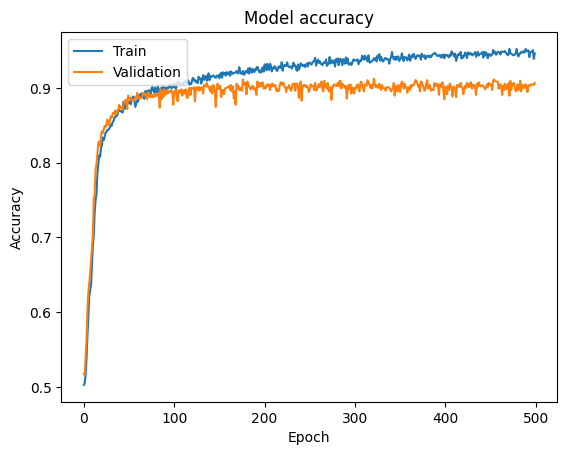

In [11]:
from matplotlib import pyplot as plt
plt.plot(history.history['avg_accuracy'])
plt.plot(history.history['val_avg_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [12]:
model = load_model('./weight_cp/weight_lstm2.hdf5')
predictionss = model.predict(X_test)


In [13]:
predictions = np.where(predictionss[-1] > 0.5, 1, 0)
y_pred = []
for p in predictions:
    y_pred.append(p[0])
y_pred = np.array(y_pred)
from sklearn.metrics import classification_report, accuracy_score
print("CLASSIFICATION REPORT OF Multi-Supervised LSTM")
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

CLASSIFICATION REPORT OF Multi-Supervised LSTM
              precision    recall  f1-score   support

           0       0.88      0.91      0.89       661
           1       0.90      0.88      0.89       662

    accuracy                           0.89      1323
   macro avg       0.89      0.89      0.89      1323
weighted avg       0.89      0.89      0.89      1323

0.891912320483749


In [14]:
for i, layer in enumerate(model.layers):
    print(layer.name, i)

input_2 0
embedding_1 1
lstm_1 2
time_distributed 3
global_average_pooling1d 4
flatten 5
multiply 6
before_split 7
tf_op_layer_split 8
concatenate 9
reshape 10
conv2d 11
batch_normalization 12
flatten_1 13
op_main 14
op_conv 15
avg 16


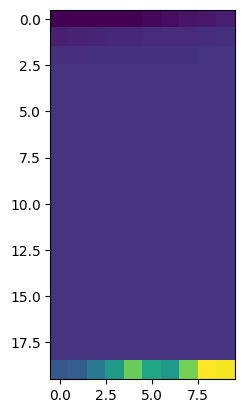

In [15]:
prr = 71
f = Model(model.input, model.layers[7].output)
predictions = f.predict(X_test)
plt.imshow(predictions[prr].reshape((20, 10)), cmap='viridis', interpolation='nearest')
plt.show()

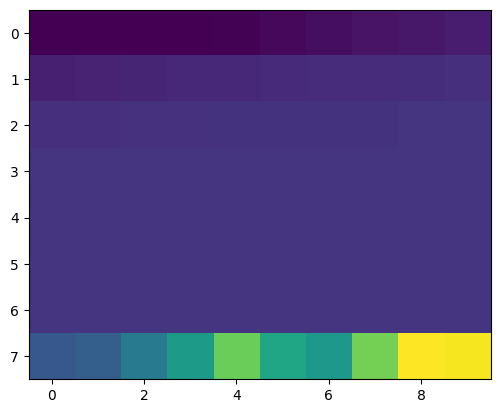

In [16]:
f = Model(model.input, model.layers[10].output)
predictions = f.predict(X_test)
plt.imshow(predictions[prr], cmap='viridis', interpolation='nearest')
plt.show()